# Telecom X Parte 2

# Tabla de contenido

## Preparación de los datos

### Extracción del archivo tratado

In [130]:
# Importando librerias

# Librerias para el análisis de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Funciones con los modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

# Funciones para el preprocesamiento
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

# Funciones para organización y creación de modelos
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV


# Módulo para la evaluación
from sklearn import metrics

In [2]:
# Importación del archivo previamente preparado
df = pd.read_csv("TelecomX_Data_prepared.csv")

# Verificando importación y primeras filas
df.head()

,customerID,Churn,tenure,PhoneService,InternetService,TechSupport,StreamingTV,StreamingMovies,Contract,Charges.Monthly,Charges.Total,Cuentas_Diarias
0,0002-ORFBO,0,9,1,DSL,Yes,Yes,No,One year,65.6,593.30,2.186667
1,0003-MKNFE,0,9,1,DSL,No,No,Yes,Month-to-month,59.9,542.40,1.996667
2,0004-TLHLJ,1,4,1,Fiber optic,No,No,No,Month-to-month,73.9,280.85,2.463333
3,0011-IGKFF,1,13,1,Fiber optic,No,Yes,Yes,Month-to-month,98.0,1237.85,3.266667
4,0013-EXCHZ,1,3,1,Fiber optic,Yes,Yes,No,Month-to-month,83.9,267.40,2.796667


### Eliminación de columnas irrelevantes

En el Análisis Exploratorio de Datos previamente realizado se eliminaron las columnas que no aportaban mucho al análisis como tal. En este caso, para el modelado predictivo, se eliminará unicamente la columna del id del cliente. Esto es debido a que esta columna no aporta información relevante al entrenamiento y desempeño del modelo.

In [3]:
# Eliminación de la columna
df.drop("customerID", axis=1, inplace=True)

# Verificación
df.columns

Index(['Churn', 'tenure', 'PhoneService', 'InternetService', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'Charges.Monthly',
       'Charges.Total', 'Cuentas_Diarias'],
      dtype='object')

### Encoding

**Encoding** se refiere a convertir las variables categoricas a numéricas, ya que los modelos solo trabajan con números. Una técnica que hace esta transformación y que mejora el desempeño del modelo se le conoce como `OneHotEncoder`. [Este enlace](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) que lleva a la **documentación oficial** explica bien su funcionamiento.

Por el momento, dejaremos la parte del encoding para el modelado predictivo. No se realizará ahora para evitar un problema conocido como **espionaje de datos**, que básicamente que el modelo "responde bien" porque encontro el examen con las respuestas a las preguntas (analogía).

### Verificación de la proporción de cancelación (churn)

In [4]:
# Cantidad de personas que abandonaron (0) y que no abandonaron (1)
df["Churn"].value_counts()

Churn
0    5398
1    1869
Name: count, dtype: int64

In [7]:
# Porcentajes de personas que abandonaron (0) y que no abandonaron (1)
round(df["Churn"].value_counts(normalize=True)*100, 2)

Churn
0    74.28
1    25.72
Name: proportion, dtype: float64

La proporción de clases vista anteriormente nos muestra clases desbalanceadas, lo que significa que cada clase no tiene la misma cantidad o similar en los datos. Por lo tanto, habría que realizar un **balanceo de clases** para que el modelo tenga un buen desempeño.

### Balanceo de clases

El **balanceo de clases** se trata de hacer que clases dicotomicas o multiples de una **variable target** tengan la misma cantidad de datos en cada clase. Este proceso es importante ya que hace que el modelo haga predicciones adecuadas en cada clase. No se desea que el modelo prediga a la perfección una clase y que no realice ninguna predicción en otra clase, queremos un *balanceo*.

De momento, este proceso se realizará en el modelado predictivo, ya que existe la técnica de **asignación de pesos** que permite balancear los datos sin crear nuevas muestras.

### Normalización o Estandarización

In [10]:
# Revisando estadísticas descriptivas para evaluar si es necesario la estandarización
df.describe()

,Churn,tenure,PhoneService,Charges.Monthly,Charges.Total,Cuentas_Diarias
count,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000,7267.000000
mean,0.257190,32.346498,0.902711,64.720098,2277.182035,2.157337
std,0.437115,24.571773,0.296371,30.129572,2268.648587,1.004319
min,0.000000,0.000000,0.000000,18.250000,0.000000,0.608333
25%,0.000000,9.000000,1.000000,35.425000,396.200000,1.180833
50%,0.000000,29.000000,1.000000,70.300000,1389.200000,2.343333
75%,1.000000,55.000000,1.000000,89.875000,3778.525000,2.995833
max,1.000000,72.000000,1.000000,118.750000,8684.800000,3.958333


Podemos ver que las variables numéricas (sin contar `Churn` ni `PhoneService`) tienen valores muy diferenciados. Se tiene que realizar una técnica de **normalización o estandarización de datos**. Esta técnica consiste en hacer que los datos tengan el "mismo tamaño" pero sin perder información.

En este proyecto se utilizarán estos escaladores para probar diferentes modelos que son sensibles a la escala de los datos (Regresión logística, SVM, KNN).

Existen varios **escaladores** (otra forma de llamarlos), pero antes de, hay que realizar un análisis dirigido para explorar las variables más a detalle.

## Correlación y Selección de variables

### Análisis de correlación

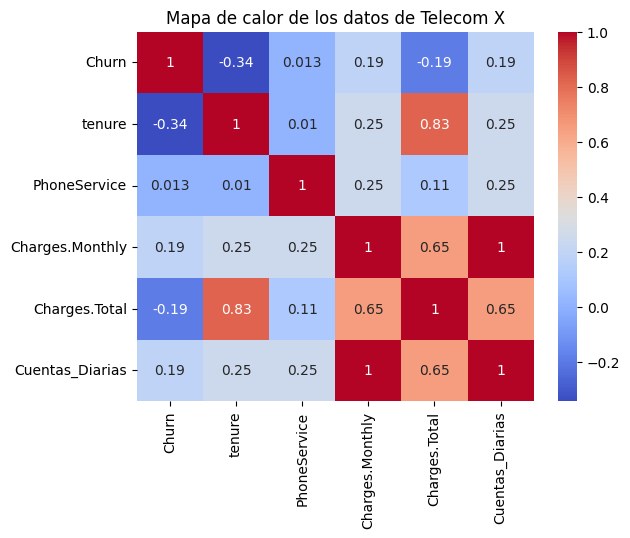

In [65]:
# Seleccionando las columnas numéricas
num_cols = df.select_dtypes(include=[np.number]).columns

# Creando el mapa de calor
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Mapa de calor de los datos de Telecom X")
plt.show()

El mapa de calor anterior nos muestran las variables con fuerte correlación (rojo) y baja correlación (azul).

En la fila de la variable `Churn` (sin contarse a sí misma, ya que por defecto las variables tienen correlación perfecta consigo mismas) las variables `tenure`, `Charges.Montly` y `Charges.Total` tienen correlaciones moderadas. La variable `PhoneService` tiene correlación baja (pero puede ser porque en realidad la variable es categorica). Por último, la variable `Cuentas_Diarias` tiene la misma correlación que `Charges.Montly`.

Sin embargo, las columnas que estén muy correlacionadas consigo mismas no se pueden utilizar ya que podrían provocar **multicolinealidad**. Las columnas `Charges.Montly` y `Cuentas_Diarias` tienen una correlación perfecta (esto es porque en la parte anterior en EDA está última variable se creo en base a `Charges.Montly`). Por lo tanto, una de estas columnas se eliminará y será `Cuentas_Diarias`, debido a que es una variable creada gracias a la otra.

### Análisis Dirigido

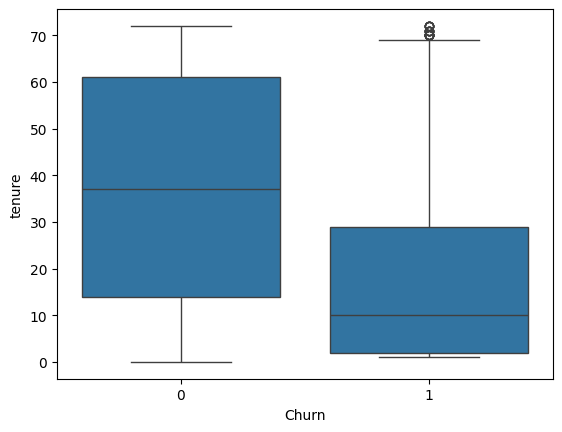

In [57]:
# Gráfico de caja entre churn y meses de contrato
sns.boxplot(data=df, x="Churn", y="tenure")
plt.show()

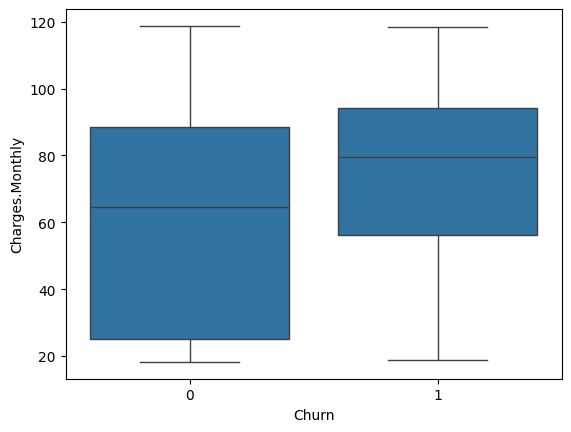

In [ ]:
# Gráfico de caja entre churn y pagos mensuales
sns.boxplot(data=df, x="Churn", y="Charges.Monthly")
plt.show()

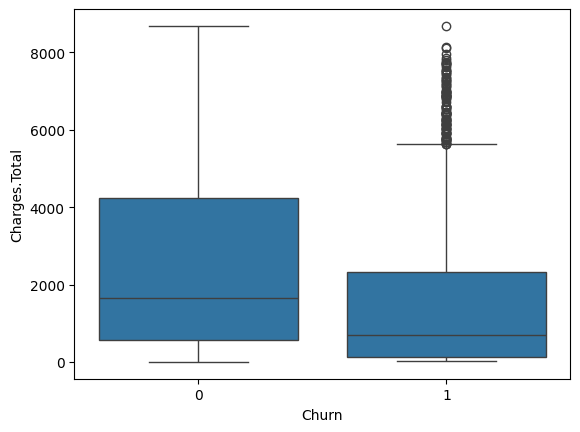

In [ ]:
# Gráfico de caja entre churn y pagos totales
sns.boxplot(data=df, x="Churn", y="Charges.Total")
plt.show()

Los gráficos de caja nos muestran la distribución de las variables por el `Churn`, pero también nos muestran la presencia de datos atípicos.

Los datos atípicos, son problemáticos para algunos tipos de escaladores. Debido a esto, se utilizará el **escalador robusto** para que los datos puedan estandarizarse sin que estos afecten el desempeño de la normalización y, por consiguiente, del modelo.

## Modelado predictivo

### Separación de datos

In [143]:
# Dividiendo las features y target
y = df.Churn
X = df.drop(["Churn", "Cuentas_Diarias"], axis=1)

# Dividiendo los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

La variable **y** solo contendrá la columna *target* `Churn`, mientras que la variable **X** se eliminarán las columnas `Churn` y `Cuentas_Diarias`. `Churn` porque no es una *feature* sino la columna target y `Cuentas_Diarias` porque puede provocar multicolineadidad por culpa de otra variable.

También, las clases están *estratificadas*, lo que significa que cada división tiene la misma cantidad de clases por igual.

### Creación de modelos

#### Dummy

Primero se creará un modelo **dummy**. Estos modelos son "modelos tontos", los cuales se utilizarán su desempeño para que modelos más inteligentes puedan (y deban) superar o no acercarse al desempeño y evaluaciones de los modelos dummy.

Como se trata de un problema de clasificación, se utilizará el `DummyClassifier`.

In [144]:
# División de columnas para las transformaciones
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Instanciando las funciones de preprocesamiento
scaler = RobustScaler()
onehot = OneHotEncoder(handle_unknown="ignore")

# Tubería para el preprocesamiento
transformer = ColumnTransformer(transformers=[
    ("scaler", scaler, num_cols),
    ("onehot", onehot, cat_cols)
])

# Instanciando el modelo de baseline
model = DummyClassifier(strategy="most_frequent")

# Creando la tubería para el modelo baseline
pipe = Pipeline(steps=[
    ("transformer", transformer),
    ("model", model)
])

# Entrenando el modelo
pipe.fit(X_train, y_train)

,steps,"[('transformer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('onehot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [145]:
# Realizando predicciones
y_pred_dummy = pipe.predict(X_test)

In [146]:
# Función para evaluar modelos
def evaluation(y_test, y_pred):
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, zero_division=0)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    metricas = {
        "Accuracy": round(accuracy, 2),
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1": round(f1, 2)
    }
    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    matrix_plot = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Abandono", "No abandono"])
    matrix_plot.plot()
    plt.show()
    return metricas

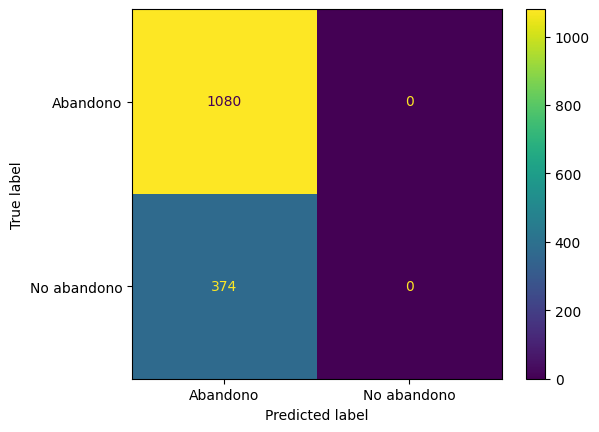

{'Accuracy': 0.74, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}

In [147]:
evaluation(y_test, y_pred_dummy)

#### Regresión Logística

Ahora toca utilizar la **regresión logística**. Se utilizará la misma tubería, cambiando el modelo. De está manera, la misma tubería se puede utilizar para evitar el **espionaje de datos**.

Cuando se instancien estos modelos dentro de la tubería, se declararán los parámetros necesarios para asignar pesos balanceados a las clases, y así el modelo pueda funcionar de mejor manera.

También se utilizará un método de **hiperparametrización** para que los modelos puedan encontrar los mejores parámetros para su desempeño (aunque para la regresión logística no se va a aplicar por ahora).

In [148]:
# Instanciando el modelo de regresión logística
lr = LogisticRegression(class_weight="balanced", random_state=42)

# Cambiando el modelo de la tubería
pipe.set_params(model=lr)

# Entrenando el modelo
pipe.fit(X_train, y_train)

,steps,"[('transformer', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('scaler', ...), ('onehot', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [149]:
# Realizando predicciones
y_pred_lr = pipe.predict(X_test)

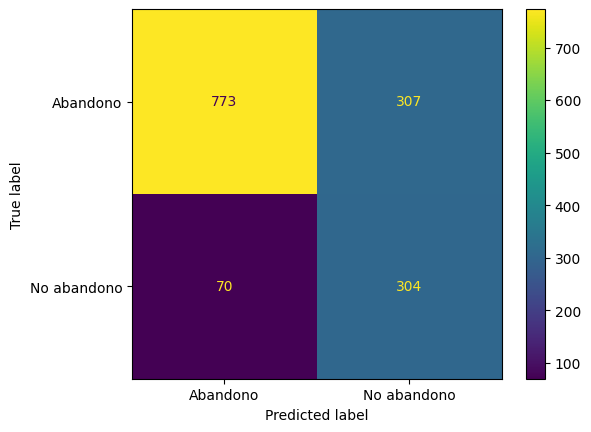

{'Accuracy': 0.74, 'Precision': 0.5, 'Recall': 0.81, 'F1': 0.62}

In [150]:
# Evaluando el modelo
evaluation(y_test, y_pred_lr)

#### SVM

In [151]:
# Instanciando el modelo svm